<a href="https://colab.research.google.com/github/Kobai/name-that-genre/blob/master/experiments/nostem_lyric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import string
import re
from os import listdir
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Input, Dropout, concatenate
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from collections import Counter
import pandas as pd

Lyrics data was acquired from https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics

In [0]:
from zipfile import ZipFile
with ZipFile('lyrics.zip', 'r') as zipObj:
  zipObj.extractall()

In [0]:
import pandas as pd
df = pd.read_csv('lyrics.csv')

In [5]:
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [0]:
# We'll drop these columns because we want to classify genres only by lyrics
df = df.drop(columns=['index', 'song', 'year', 'artist'])

In [0]:
df.to_csv('small_lyrics.csv', index=False)

In [8]:
# Print out of the lyrics for the first song. As we can see, there's a lot of cleaning to be done
df['lyrics'].head()[0]

"Oh baby, how you doing?\nYou know I'm gonna cut right to the chase\nSome women were made but me, myself\nI like to think that I was created for a special purpose\nYou know, what's more special than you? You feel me\nIt's on baby, let's get lost\nYou don't need to call into work 'cause you're the boss\nFor real, want you to show me how you feel\nI consider myself lucky, that's a big deal\nWhy? Well, you got the key to my heart\nBut you ain't gonna need it, I'd rather you open up my body\nAnd show me secrets, you didn't know was inside\nNo need for me to lie\nIt's too big, it's too wide\nIt's too strong, it won't fit\nIt's too much, it's too tough\nHe talk like this 'cause he can back it up\nHe got a big ego, such a huge ego\nI love his big ego, it's too much\nHe walk like this 'cause he can back it up\nUsually I'm humble, right now I don't choose\nYou can leave with me or you could have the blues\nSome call it arrogant, I call it confident\nYou decide when you find on what I'm working 

## Data Preparation

In [0]:
def clean_lyrics(doc):
  # stemmer = PorterStemmer()
  # We don't really care about the line breaks. we want to see the lyrics as a single sequence
  doc.replace('\n', ' ') 
  tokens = doc.split()

  # Remove the punctuation and only keep words with alphabet characters
  re_punc = re.compile(f'[{re.escape(string.punctuation)}]') 
  tokens = [re_punc.sub('',w) for w in tokens] 
  tokens = [word for word in tokens if word.isalpha()]

  # Remove stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]

  # Remove 1 letter words and lower case everything
  tokens = [word for word in tokens if len(word) >1]
  tokens = [word.lower() for word in tokens]

  # Stem the words using porter stemmer
  # tokens = [stemmer.stem(word) for word in tokens]
  return ' '.join(tokens)

def is_english(doc):
  tokens = doc.split()
  counter = 0
  # setting threshold for number of non-english words because contractions like didn't are not counted as english (room for improvement)
  threshold = int(len(tokens) * 0.3)
  for token in tokens:
    if not wordnet.synsets(token):
      counter +=1
    if counter >= threshold:
      return False
  return True

In [10]:
clean_lyrics(df['lyrics'].head()[0])

'oh baby you know im gonna cut right chase some women made like think created special purpose you know whats special you feel its baby lets get lost you dont need call work cause youre boss for real want show feel consider lucky thats big deal why well got key heart but aint gonna need id rather open body and show secrets didnt know inside no need lie its big wide its strong wont fit its much tough he talk like cause back he got big ego huge ego love big ego much he walk like cause back usually im humble right dont choose you leave could blues some call arrogant call confident you decide find im working damn know im killing legs better yet thighs matter fact smile maybe eyes boy site see kind something like its big wide its strong wont fit its much tough talk like cause back got big ego huge ego but love big ego much walk like cause back walk like cause back talk like cause back back back walk like cause back its big wide its strong wont fit its much tough he talk like cause back he go

In [0]:
# Looks pretty good so we'll run the clean function on all the lyrics
df['lyrics'] = df['lyrics'].astype(str).apply(lambda x: clean_lyrics(x))

In [0]:
df = df[df['lyrics'] != 'nan' ]

In [0]:
df = df[df.apply(lambda x: is_english(x['lyrics']), axis=1)]

In [0]:
df.to_csv('clean_lyrics.csv', index=False)

## EDA

In [0]:
df = pd.read_csv('clean_lyrics.csv')

From running the cell below, we can see that the genres are not well distributed. The dataset is heavily weighted towards Rock

Pop: 31235
Hip-Hop: 19826
Not Available: 16063
Rock: 93297
Metal: 20497
Other: 3552
Country: 13277
Jazz: 6620
Electronic: 6225
Folk: 1584
R&B: 2995
Indie: 2748


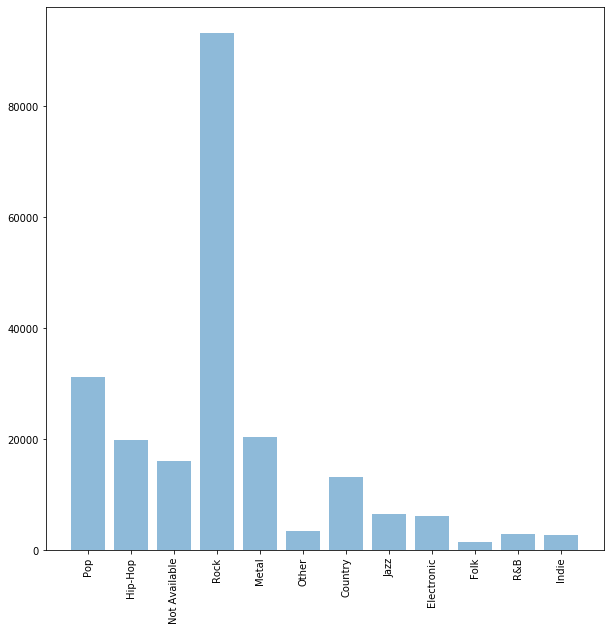

In [16]:
fig, ax = plt.subplots(figsize=(10,10)) 

counts = []
for genre in df['genre'].unique().tolist():
  print(f'{genre}: {df[df["genre"] == genre]["genre"].count()}')
  counts.append(df[df["genre"] == genre]["genre"].count())
  
objects = df['genre'].unique().tolist()
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize=10, rotation=90)
plt.show()

In [0]:
# To narrow the focus of this project, we'll remove the Not Availbel and Other labels as well as labels with limited data
df = df[df['genre'] != 'Not Available']
df = df[df['genre'] != 'Other']
df = df[df['genre'] != 'Folk']
df = df[df['genre'] != 'Indie']
df = df[df['genre'] != 'R&B']
df = df[df['genre'] != 'Jazz']
df = df[df['genre'] != 'Electronic']
genres = df['genre'].unique().tolist()

count    177368.000000
mean        805.277649
std         556.811785
min          11.000000
25%         463.000000
50%         666.000000
75%         955.000000
max       28786.000000
Name: strlen, dtype: float64


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


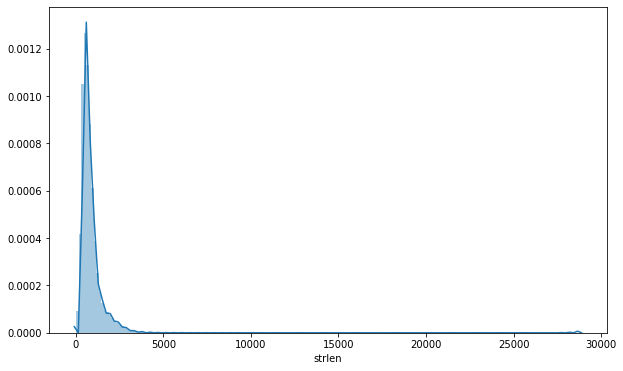

In [18]:
df['strlen'] = df['lyrics'].str.len()
print(df['strlen'].describe())
fig, ax = plt.subplots(figsize=(10,6)) 
sn.distplot(df['strlen'],bins=200)

In [0]:
df = df[df['strlen'] >= 30]
df = df[df['strlen'] <= 2200]

In [0]:
lines = df['lyrics'].tolist()

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)

In [22]:
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab Size: {vocab_size}')
max_length = max([len(s.split()) for s in lines])
print(f'Max Length: {max_length}')

Vocab Size: 168290
Max Length: 472


In [0]:
def encode_docs(vocab_size, max_length, docs):
  encoded = tokenizer.texts_to_sequences(docs)
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

In [0]:
def define_model(vocab_size, max_length):
  inputs1 = Input(shape=(max_length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(max_length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(max_length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  merged = concatenate([flat1, flat2, flat3])
  dense1 = Dense(64, activation='relu')(merged)
  dense2 = Dense(32, activation='relu')(dense1)
  outputs = Dense(len(genres), activation='softmax')(dense2)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [0]:
def test_model(model):
  rev_genre_dict = dict(zip(range(len(genres)), genres))
  preds = model.predict([Xtest, Xtest, Xtest])
  preds = [np.argmax(pred) for pred in preds]
  labels = [np.argmax(label) for label in ytest]
  print(classification_report(labels, preds))
  cm = confusion_matrix(labels, preds)
  cm_df = pd.DataFrame(cm, index=genres, columns=genres)
  fig, ax = plt.subplots(figsize=(18,11)) 
  sn.set(font_scale=1.4)
  sn.heatmap(cm_df, annot=True, annot_kws={'size': 12}, linewidths=0.5, cmap="Blues") 

In [26]:
X = encode_docs(tokenizer, max_length, lines)
genre_dict = dict(zip(genres, range(len(genres))))
print(genre_dict)
y = df['genre'].astype(str).apply(lambda x: genre_dict[x]).tolist()
y = to_categorical(y, num_classes=len(genres))

{'Pop': 0, 'Hip-Hop': 1, 'Rock': 2, 'Metal': 3, 'Country': 4}


In [0]:
from sklearn.model_selection import train_test_split
(Xtrain, Xtest, ytrain, ytest) = train_test_split(X,y,test_size=0.2, random_state=42)

In [28]:
model = define_model(vocab_size, max_length)
model.fit([Xtrain, Xtrain, Xtrain], ytrain, epochs=5, batch_size=64)
model.save('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 472)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 472)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 472)]        0                                            
_____________________________________________________________________________________________

              precision    recall  f1-score   support

           0       0.55      0.38      0.45      6175
           1       0.85      0.71      0.77      2936
           2       0.69      0.84      0.76     18507
           3       0.74      0.52      0.62      4008
           4       0.52      0.44      0.48      2659

    accuracy                           0.68     34285
   macro avg       0.67      0.58      0.62     34285
weighted avg       0.67      0.68      0.67     34285



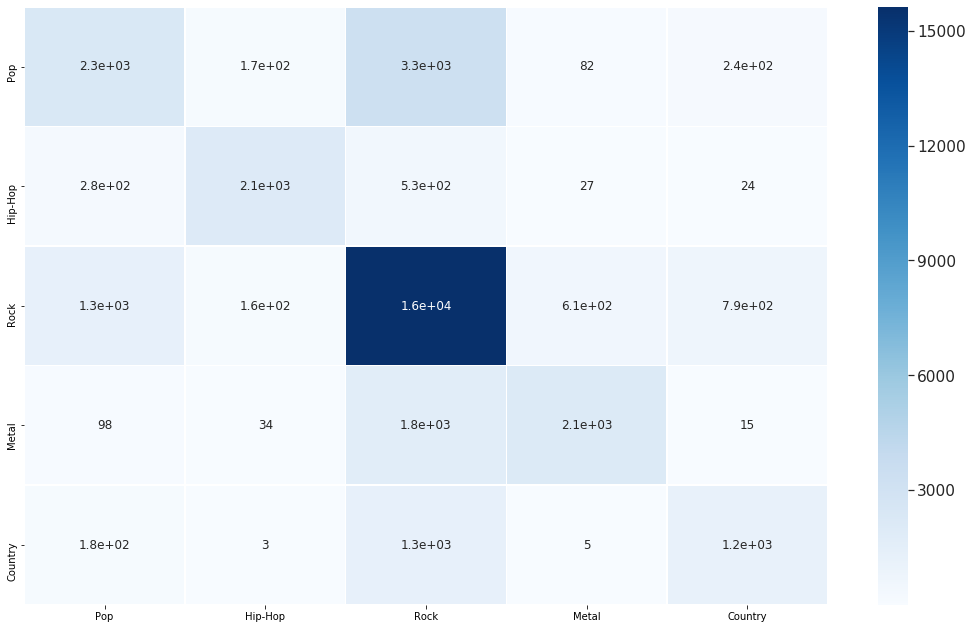

In [29]:
test_model(model)